<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/MultiSkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
The code in this notebook is adopted from:

https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=IUM0UA1qJaVB

I have adapted it for use with the skin cancer data (big and little) found in the wiki:

https://knowledge.depaul.edu/display/DNLP/Tasks+and+Data
'''

# Colab currenly defaults to TensorFlow 1.15, but we need 2.0 or greater

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
# Manual Parameters - these are not automatically generated and need to be set each runtime

# Number of training epochs (authors recommend between 2 and 4)
EPOCHS = 2

# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
BATCH_SIZE = 16

# If there are sentences longer than 512 tokens, we will crash.
MAX_LEN = 128

# Learning rate: 5e-5, 3e-5, 2e-5 are the ones recommended
LEARNING_RATE = 2e-5

WARMUP = .1

# Model we are fine-tuning
# MODEL_TYPE = 'pretrained-bert-base-uncased'
MODEL_TYPE = 'bert-base-uncased'

# Load BERT checkpoint from pretraining or use provided model
# BERT_PATH = "drive/My Drive/colab/bert/bert_pytorch/torch_model.tar.gz"
BERT_PATH = 'bert-base-uncased'

PRETRAINING_MODEL_ID = "none"

# Type of pretraining we used: none, mlmnsp, nspmlm, both
PRETRAINING_MODEL_TYPE = "none"

# Cost sensitivity
COST_SENSITIVITY = 0

# If we do crossvalidation
KFOLD = 0

NOTES = "Initial skin cancer dataset fine-tuning"

In [3]:
# We are going to use Colab's (free) GPU. To do this, goto Edit->Notebook Settings->Hardware Accelerator and select GPU

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Make sure PyTorch is installed - will use with Hugging Face Transformers
# Hugging Face library currently accepted as most powerful PyTorch interface with BERT

!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 8.5MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 


In [5]:
# Take care of the resf of the imports

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
# If gpu availale, we have to set it up.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [7]:
# Before importing the data, we must mount Google Drive to Colab notebook.

# Each time the notebook is run, Colab must request authorization to remount to Google Drive.
# I have not found a way arouund this yet. Even though I am a pro (paying) user, Colab
#   will not allow me to let datasets persist after runtime ceases.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# I downloaded the data directly from the wiki to my Google Drive for pseudo-dynamic access.

DATA_PATH = "drive/My Drive/colab/data/"
DATA_NAME = "EBA1415-SkinCancer-big-sentences.tsv"
df = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=0, names=['file', 'relation', 's_num', 'sentence'])

In [9]:
# Let's take a peak

df.shape
df.head(10)

,file,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,R-1-2,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,R-1-2,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,O,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,O,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,R-12-3,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,O,10.0,That would be your skin protects you.


In [10]:
# Create sentence and label lists
sentences = df.sentence.values

# Add special tokens at the beginning and end of each sentence to comply with BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.relation.values

In [11]:
# Now that our [CLS] and [SEP] tokens are in place, we are ready for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 673926.08B/s]


First sentence tokenized:  ['[CLS]', 'this', 'essay', 'is', 'about', 'skin', 'damage', ',', 'latitude', 'and', 'direct', 'sunlight', ',', 'skin', 'cancer', 'and', 'latitude', ',', 'your', 'skin', 'protects', 'you', 'and', 'about', 'sun', '##burn', '##s', '.', '[SEP]']


In [12]:
'''
For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set
'''

# For now, we will simply delete the tokenized_texts greater than MAX_LEN.

# We need to strip out the sentences greater than MAX_LEN tokens
original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 12 sentences greater than 128


In [13]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [14]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [16]:
# At this point we must convert our labels from strings to ints (required for tensorization)

# First we are going to create an array of all possible labels
label_types = {}
for i in range(len(labels)):
  if labels[i] not in label_types:
    label_types.update({labels[i] : len(label_types)})
print("Total labels_types: {0}\nLabels: {1}".format(len(label_types),str(label_types)))

Total labels_types: 51
Labels: {'O': 0, 'R-1-2': 1, 'R-12-3': 2, 'R-1-50': 3, 'R-2-3': 4, 'R-3-4': 5, 'R-5-6': 6, 'R-2-50': 7, 'R-4-5': 8, 'R-3-50': 9, 'R-2-5': 10, 'R-5-50': 11, 'R-4-50': 12, 'R-6-50': 13, 'R-2-4': 14, 'R-1-5': 15, 'R-11-50': 16, 'R-11-12': 17, 'R-4-4': 18, 'R-5-4': 19, 'R-4-6': 20, 'R-12-2': 21, 'R-3-6': 22, 'R-3-5': 23, 'R-1-3': 24, 'R-6-5': 25, 'R-5-5': 26, 'R-1-4': 27, 'R-12-12': 28, 'R-11-3': 29, 'R-12-5': 30, 'R-11-5': 31, 'R-12-50': 32, 'R-50-2': 33, 'R-2-2': 34, 'R-11-4': 35, 'R-6-4': 36, 'R-50-5': 37, 'R-12-4': 38, 'R-5-11': 39, 'R-50-4': 40, 'R-6-3': 41, 'R-2-6': 42, 'R-4-11': 43, 'R-2-1': 44, 'R-50-3': 45, 'R-5-12': 46, 'R-2-11': 47, 'R-3-11': 48, 'R-3-2': 49, 'R-50-1': 50}


In [17]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels))
labels = [label_types.get(l) for l in labels]
print("New labels: ",str(labels))

Old labels:  ['O', 'O', 'O', 'O', 'R-1-2', 'R-1-2', 'O', 'O', 'R-12-3', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'R-1-50', 'R-1-2', 'R-2-3', 'O', 'R-3-4', 'O', 'R-5-6', 'O', 'O', 'O', 'O', 'O', 'R-2-50', 'R-2-50', 'R-1-2', 'R-1-50', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'R-5-6', 'R-4-5', 'O', 'O', 'R-1-2', 'R-1-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'R-3-50', 'O', 'R-1-2', 'R-2-5', 'R-5-50', 'O', 'R-2-3', 'O', 'R-3-4', 'O', 'R-5-50', 'O', 'R-3-50', 'R-1-50', 'R-2-50', 'O', 'O', 'O', 'R-1-50', 'O', 'O', 'O', 'R-4-50', 'R-1-50', 'R-2-50', 'O', 'R-1-50', 'R-2-50', 'R-1-50', 'R-5-50', 'O', 'R-5-50', 'R-4-5', 'O', 'O', 'O', 'R-5-50', 'R-3-50', 'O', 'R-5-6', 'R-2-5', 'O', 'R-2-5', 'R-1-2', 'O', 'R-3-4', 'O', 'R-2-3', 'R-2-5', 'O', 'R-3-50', 'R-5-50', 'R-5-50', 'R-5-50', 'O', 'O', 'R-5-6', 'R-6-50', 'R-5-6', 'O', 'R-4-5', 'R-4-5', 'R-5-50', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'R-1-50', 'O', 'R-

In [18]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [19]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [20]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [21]:
# This is where the fine-tuning comes in. We must train the model for our specific task.

# We will first modify pre-trained BERT for our specific task, then continue training on our data until the entire model
#   is well-suited for our task.

model = BertForSequenceClassification.from_pretrained(BERT_PATH, num_labels=len(labels))
model.cuda()

100%|██████████| 407873900/407873900 [00:14<00:00, 27812788.11B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [22]:
'''
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [23]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.9326805060416197


Epoch:  50%|█████     | 1/2 [02:05<02:05, 125.28s/it]

Validation Accuracy: 0.732473544973545
Train loss: 0.9627275538655509


Epoch: 100%|██████████| 2/2 [04:10<00:00, 125.08s/it]

Validation Accuracy: 0.7232142857142857


In [26]:
STATS_PATH = "drive/My Drive/colab/stats/skin_cancer_fine_tuning_stats.csv"
def getLastModelNumber():
  try:
    with open(STATS_PATH, "r") as f:
      f_list = list(f)
      latest = f_list[-1].split(',')
      return int(latest[0])
  except:
    return -1

In [27]:
# Will take a break from saving models - takes up too much space

# import os
# import itertools

# MODEL_PATH = "drive/My Drive/colab/models/" 
# MODEL_SAVE_NAME = 'skin_cancer_fine_tuning'

# # Helper function for auto-saving model incrementally

# # This code is originally from StackExchange via "Tanner," but I altered it for use here
# # https://gis.stackexchange.com/questions/27410/how-auto-increment-output-file-names-in-python-script

# # Modified with code from Gareth Latty via StackOverflow
# # https://stackoverflow.com/questions/13673781/splitting-a-string-where-it-switches-between-numeric-and-alphabetic-characters
# def getNextFileInt(output_folder):
#     highest_num = 0
#     for f in os.listdir(output_folder):
#       temp = ""
#       for c in f:
#         if c.isdigit():
#           temp += c
#         if len(temp) > 0 and int(temp) > highest_num:
#           highest_num = int(temp)
#     return highest_num + 1

In [28]:
# We will use this in the future to refer to the current model
current_file_n_str = str(getLastModelNumber() + 1)
current_file_n_str

'11'

In [29]:
# # We save the model so that we can access it later

# if not os.path.isfile(MODEL_PATH + MODEL_SAVE_NAME):
#   torch.save(model.state_dict(), MODEL_PATH + MODEL_SAVE_NAME)
# else:
#   # Get the model number to save
#   current_file_n_str = str(getNextFileInt(MODEL_PATH))
#   print("This will be file",current_file_n_str)
#   torch.save(model.state_dict(), MODEL_PATH + MODEL_SAVE_NAME + current_file_n_str)

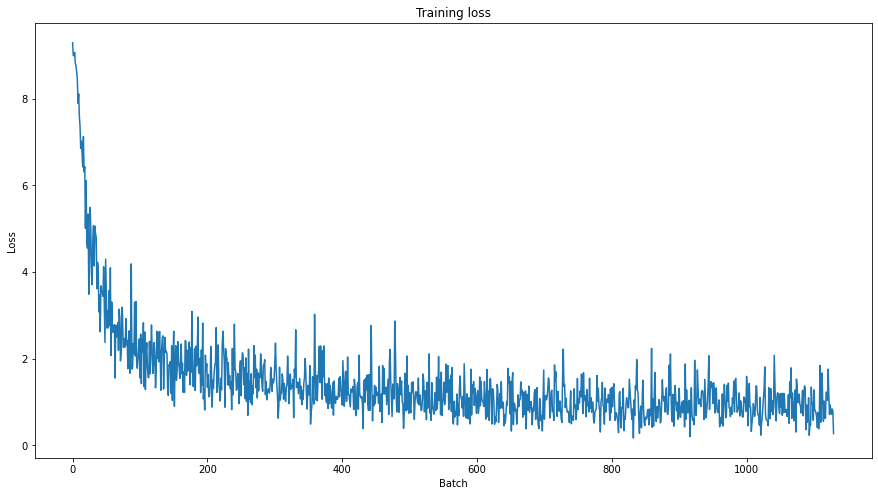

In [30]:
# Let's take a look!

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [31]:
# Now we will validate on our testing data
DATA_PATH_TEST = "drive/My Drive/colab/data/"
DATA_NAME_TEST = "EBA1415-SkinCancer-little-sentences.tsv"
df_test = pd.read_csv(DATA_PATH_TEST + DATA_NAME_TEST, delimiter='\t', header=0, names=['file', 'relation', 's_num', 'sentence'])

In [32]:
# Create sentence and label lists
sentences_test = df_test.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]

In [33]:
# Get labels
labels_test = df_test.relation.values

In [34]:
# Convert labels to ints

print("Pre-changed test labels: ",str(labels_test))
labels_test = [label_types.get(l) for l in labels_test]
print("Changed test labels: ",str(labels_test))

Pre-changed test labels:  ['O' 'R-1-50' 'R-1-2' ... 'R-4-50' 'O' 'O']
Changed test labels:  [0, 3, 1, 1, 4, 11, 11, 0, 7, 9, 7, 9, 7, 1, 3, 9, 5, 5, 14, 11, 13, 20, 13, 0, 0, 0, 0, 7, 7, 1, 0, 3, 0, 2, 9, 22, 23, 23, 0, 0, 0, 6, 13, 0, 6, 1, 0, 0, 3, 11, 10, 10, 6, 13, 11, 0, 11, 7, 7, 7, 1, 0, 0, 11, 25, 10, 7, 7, 1, 0, 1, 3, 0, 42, 17, 2, 0, 17, 2, 17, 2, 6, 11, 6, 0, 3, 3, 1, 7, 0, 0, 0, 22, 9, 6, 8, 10, 13, 0, 0, 11, 11, 7, 0, 10, 19, 20, 13, 0, 0, 0, 0, 7, 0, 0, 4, 5, 12, 9, 11, 8, 0, 0, 0, 1, 1, 4, 2, 11, 8, 0, 6, 13, 11, 7, 3, 14, 0, 0, 0, 0, 0, 0, 7, 7, 4, 5, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 9, 7, 1, 1, 15, 24, 19, 8, 0, 0, 0, 0, 0, 0, 5, 0, 8, 6, 6, 13, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 11, 8, 13, 13, 0, 6, 13, 0, 0, 0, 0, 1, 7, 3, 13, 6, 8, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 12, 20, 13, 3, 1, 0, 0, 0, 0, 17, 2, 0, 17, 3, 1, 10, 7, 0, 0, 1, 6, 13, 7, 7, 0, 6, 6, 13, 9, 11, 0, 11, 0, 0, 0, 0, 0, 0, 3, 0, 0, 7, 7, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [35]:
# Get rid of labels that were not in the training data

original_test_label_length = len(labels_test)

tokenized_texts_test = [tokenized_texts_test[i] for i in range(len(tokenized_texts_test)) if labels_test[i] != None]
labels_test = [labels_test[i] for i in range(len(labels_test)) if labels_test[i] != None]

print("Removed {0} labels of type None".format(original_test_label_length - len(labels_test)))

Removed 5 labels of type None


In [36]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
# Pad our input tokens
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks_test = []

In [37]:
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

In [38]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

In [39]:
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

In [40]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test, true_labels_test = [], []

In [41]:
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits_test)
  true_labels_test.append(label_ids_test)

In [42]:
# Flatten the predictions and true values
flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
flat_true_labels_test = [item for sublist in true_labels_test for item in sublist]

In [43]:
# # At this point we must create a binary array to determine which answers were answered correctly
# test_results_array = np.array(flat_predictions_test == flat_true_labels_test)
# test_results_array = test_results_array.astype(int)
# test_results_array[:100]

In [44]:
# Create the file to store the stats of the model if it doesn't already exist

import os
f = None
if not os.path.isfile(STATS_PATH):
  f = open(STATS_PATH, "w")
  f.write("number,datetime,bert_model,hugging_face,max_len,epochs,batch_size,\
            optimizer,learning_rate,warmup,pretraining_model_id,pretraining_model_type,\
            cost_sensitivity,accuracy,macro_prec,macro_recall,macro_f1,macro_support,\
            weighted_prec,weighted_recall,weighted_f1,weighted_support,kfold,notes\n")
  print("skin_cancer_stats.csv NOT found - creating")
  f.close()

In [45]:
# from sklearn.metrics import classification_report

# y_pred = flat_predictions_test
# y = flat_true_labels_test

# classification_dict = classification_report(y, y_pred, labels=None, target_names=None, \
#                       sample_weight=None, digits=2, output_dict=True, zero_division=1)

# # Create arrays of precisions, recalls, f1s to recalculate average
# precisions = []
# recalls = []
# f1s = []
# supports = []

# # We must alter the classification dictionary to update the f1_score and recall keys to be 1 instead of 0
# # In this example, precision/recall/f1 scores of 0 are set to 1

# classification_dict_converted = {}

# for k,v in classification_dict.items():
#   if k.isdigit():

#     if float(v['recall']) == 0.0: v['recall'] = 1.0
#     recalls.append(v['recall'])

#     if float(v['f1-score']) == 0.0: v['f1-score'] = 1.0
#     f1s.append(v['f1-score'])

#     if float(v['precision']) == 0.0: v['precision'] = 1.0
#     precisions.append(v['precision'])

#     supports.append(v['support'])

#     # Convert dictionary keys back to our original labels
#     original_key = next((key for key in label_types if label_types[key] == int(k)), None)
#     classification_dict_converted.update({ original_key : v })

#     print(original_key + " : " + str(classification_dict_converted[original_key]))

#   # Otherwise, we are at the end of the dict and edit the averages to account for the newly replaced 0s
#   else:
#     if k == 'macro avg':
#       precision = sum(precisions)/len(precisions)
#       recall = sum(recalls)/len(recalls)
#       f1 = sum(f1s)/len(f1s)

#       v['precision'] = precision
#       v['recall'] = recall
#       v['f1-score'] = f1

#     if k == 'weighted avg':
#       weighted_precisions = [precisions[i]*supports[i] for i in range(len(precisions))]
#       weighted_recalls = [recalls[i]*supports[i] for i in range(len(recalls))]
#       weighted_f1s = [f1s[i]*supports[i] for i in range(len(f1s))]

#       total_supports = v['support']

#       precision = sum(weighted_precisions)/total_supports
#       recall = sum(weighted_recalls)/total_supports
#       f1 = sum(weighted_f1s)/total_supports

#       v['precision'] = precision
#       v['recall'] = recall
#       v['f1-score'] = f1

#     classification_dict_converted.update({ k : v })
#     print("\n" + k + " : " + str(classification_dict_converted[k]))

# accuracy = classification_dict_converted['accuracy']

In [46]:
from sklearn.metrics import classification_report

y_pred = flat_predictions_test
y = flat_true_labels_test

classification_dict = classification_report(y, y_pred, labels=None, target_names=None, \
                      sample_weight=None, digits=2, output_dict=True, zero_division=1)

# Create arrays of precisions, recalls, f1s to recalculate average
precisions = []
recalls = []
f1s = []
supports = []

# We must alter the classification dictionary to update the f1_score and recall keys to be 1 instead of 0
# In this example, precision/recall/f1 scores of 0 are ignored

classification_dict_stripped = {}

for k,v in classification_dict.items():
  if k.isdigit():

    if float(v['precision']) != 0.0 and float(v['recall']) != 0.0 and float(v['f1-score']) != 0.0:
      recalls.append(v['recall'])
      f1s.append(v['f1-score'])
      precisions.append(v['precision'])
      supports.append(v['support'])

      # Convert dictionary keys back to our original labels
      original_key = next((key for key in label_types if label_types[key] == int(k)), None)
      classification_dict_stripped.update({ original_key : v })

      print(original_key + " : " + str(classification_dict_stripped[original_key]))
      
  # Otherwise, we are at the end of the dict and edit the averages to account for the newly replaced 0s
  else:
    if k == 'macro avg':
      precision = sum(precisions)/len(precisions)
      recall = sum(recalls)/len(recalls)
      f1 = sum(f1s)/len(f1s)

      v['precision'] = precision
      v['recall'] = recall
      v['f1-score'] = f1

    if k == 'weighted avg':
      weighted_precisions = [precisions[i]*supports[i] for i in range(len(precisions))]
      weighted_recalls = [recalls[i]*supports[i] for i in range(len(recalls))]
      weighted_f1s = [f1s[i]*supports[i] for i in range(len(f1s))]

      total_supports = sum(supports)

      precision = sum(weighted_precisions)/total_supports
      recall = sum(weighted_recalls)/total_supports
      f1 = sum(weighted_f1s)/total_supports

      v['precision'] = precision
      v['recall'] = recall
      v['f1-score'] = f1
      v['support'] = total_supports

    classification_dict_stripped.update({ k : v })

    print("\n" + k + " : " + str(classification_dict_stripped[k]))

O : {'precision': 0.9177057356608479, 'recall': 0.9169435215946844, 'f1-score': 0.9173244702949731, 'support': 1204}
R-1-2 : {'precision': 0.6303030303030303, 'recall': 0.7819548872180451, 'f1-score': 0.6979865771812079, 'support': 133}
R-12-3 : {'precision': 0.6, 'recall': 0.45454545454545453, 'f1-score': 0.5172413793103449, 'support': 66}
R-1-50 : {'precision': 0.6597938144329897, 'recall': 0.5714285714285714, 'f1-score': 0.6124401913875598, 'support': 112}
R-2-3 : {'precision': 0.5081967213114754, 'recall': 0.5344827586206896, 'f1-score': 0.5210084033613445, 'support': 58}
R-3-4 : {'precision': 0.6333333333333333, 'recall': 0.6785714285714286, 'f1-score': 0.6551724137931035, 'support': 56}
R-5-6 : {'precision': 0.6865671641791045, 'recall': 0.4, 'f1-score': 0.5054945054945055, 'support': 115}
R-2-50 : {'precision': 0.44921875, 'recall': 0.6845238095238095, 'f1-score': 0.5424528301886793, 'support': 168}
R-4-5 : {'precision': 0.45544554455445546, 'recall': 0.8363636363636363, 'f1-sco

In [47]:
ACCURACY = classification_dict_stripped['accuracy']

macro = classification_dict_stripped["macro avg"]
MACRO_F1 = macro["f1-score"]
MACRO_PREC = macro["precision"]
MACRO_RECALL = macro["recall"]
MACRO_SUPPORT = macro["support"]

weighted = classification_dict_stripped["weighted avg"]
WEIGHTED_F1 = weighted["f1-score"]
WEIGHTED_PREC = weighted["precision"]
WEIGHTED_RECALL = weighted["recall"]
WEIGHTED_SUPPORT = weighted["support"]

In [48]:
# Capture HuggingFace type

hf_arr = str(type(model)).split('.')
HF_TYPE = hf_arr[2]
HF_TYPE = ''.join(filter(str.isalnum, HF_TYPE))
HF_TYPE

'BertForSequenceClassification'

In [49]:
# Capture optimizer type

opt_arr = str(type(optimizer)).split('.')
OPTIMIZER_TYPE = opt_arr[2]
OPTIMIZER_TYPE = ''.join(filter(str.isalnum, OPTIMIZER_TYPE))
OPTIMIZER_TYPE

'BertAdam'

In [50]:
# Get date and time
import datetime
import pytz

date = str(datetime.datetime.now(tz = pytz.timezone('US/Central')))
date = date.split(' ')
time = date[1]
date = date[0]
h, m = [time.split(':')[0], time.split(':')[1]]

DATE_TIME = date + ' ' + h + ':' + m + " CT"

In [51]:
NUM = int(current_file_n_str)

In [52]:
# Add line to stats, then save and close
with open(STATS_PATH, "a") as f:
  f.write("{0},{1},{2},{3},{4},{5},{6},{7},{8},\
  {9},{10},{11},{12},{13},{14},{15},{16},{17},\
  {18},{19},{20},{21},{22},{23}\n".format(NUM,DATE_TIME,MODEL_TYPE,HF_TYPE,MAX_LEN,EPOCHS,BATCH_SIZE,
                                          OPTIMIZER_TYPE,LEARNING_RATE,WARMUP,PRETRAINING_MODEL_ID,PRETRAINING_MODEL_TYPE,
                                          COST_SENSITIVITY,ACCURACY,MACRO_PREC,MACRO_RECALL,MACRO_F1,MACRO_SUPPORT,
                                          WEIGHTED_PREC,WEIGHTED_RECALL,WEIGHTED_F1,WEIGHTED_SUPPORT,KFOLD,NOTES))

In [53]:
import keras
import sklearn
import pytorch_pretrained_bert

print("TensorFlow version:",tf.__version__)
print("PyTorch version",torch.__version__)
print("Keras version:",keras.__version__)
print("Scikit-Learn version:",sklearn.__version__)
print("pytorch_pretrained_bert version:",pytorch_pretrained_bert.__version__)
print("Pandas version:",pd.__version__)
print("NumPy version:",np.__version__)

TensorFlow version: 2.3.0
PyTorch version 1.6.0+cu101
Keras version: 2.4.3
Scikit-Learn version: 0.22.2.post1
pytorch_pretrained_bert version: 0.6.2
Pandas version: 1.0.5
NumPy version: 1.18.5
